# Analise de vendas para ativar ou inativar produto para importação.

Dataset utilizado contem os dados de vendas dos produtos da empresa X de 2016 a 2019.
O produto A, B e C são importados e levam 3 meses para serem entregues pelo fornecedor na china.

# Objetivo

1 - Verificar o hisorico de vendas e estoque disponivel de um produto e analisar se deve ser descontinuado ou adiquirido, tendo em vista as necesidades e estrategias comerciais da empresa.



## O Dicionário de Dados

**Num. Pedido**: Numero do documento de vendas

**DT Emissao, Mes,  Ano e Mes-ano**: Data em que a venda foi efetuada

**Nome Cliente**: Nome generico do cliente

**Produto**: Codigo do Produto

**Descricao**: Descrição do Produto

**Quantidade**: Quantidade vendida do produto

**Estoque**: Estoque atual do produto no ato da venda

**Compra**: Indica se deve ser emitido ordem de compra do produto.

adicionar valor unitário, custo unitário, margem e o hanking de cliente (A, B, C)

**prcunit**: Preço unitário do produto

**custounit**: Custo unitário do produto no dia da venda levando em consideração cambio de dolar, frete, estoque, despesas operacionais e impostos.

**margem**: Lucro bruto sobre o item vendido

**tipcli**: Classificação do cliente (hanking)

## Importando as bibliotecas

In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Acessando os dados

In [135]:
# Acessando banco de dados Mysql
# Obs: Antes será necessário instalar o mysql.connector via commando no cmd (pip install mysql-connector-python)

In [136]:
from datetime import date
import mysql.connector

db_connection = mysql.connector.connect(host="108.167.132.74", user="vetro057_dcroot", passwd="@dc2020dc", database="vetro057_dc")

data = pd.read_sql('SELECT * FROM fat19', con=db_connection)
  
db_connection.commit()
db_connection.close()

In [137]:
#Exibindo os primeios 5 registros do dataset
data.head(5)

,cod,numpedido,dataemissao,mes,ano,nomecliente,tipcli,produto,qtde,prcunit,total,custounit,margem,estoque,compra
0,1,1371.0,03/01/2019,1,2019,CLI3460,A,5140,240,23.64,5673.60,10.232,13.408,530,COMPRA
1,2,1378.0,03/01/2019,1,2019,CLI3433,A,5140,48,23.64,1134.72,10.232,13.408,563,COMPRA
2,3,1388.0,03/01/2019,1,2019,CLI3455,A,5140,16,23.64,378.24,10.232,13.408,229,COMPRA
3,4,1391.0,03/01/2019,1,2019,CLI3587,A,5140,8,23.64,189.12,10.232,13.408,269,COMPRA
4,5,NaN,03/01/2019,1,2019,CLI3472,A,5140,8,23.64,189.12,9.050,14.590,119,COMPRA


In [ ]:
data.corr()

In [ ]:
#convertendo alguns tipos de dados:

data['mes'] = data['mes'].astype(int)

## Exploração dos dados


In [138]:
# Informaçõe gerais.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 15 columns):
cod            2823 non-null int64
numpedido      2609 non-null float64
dataemissao    2823 non-null object
mes            2823 non-null object
ano            2823 non-null object
nomecliente    2823 non-null object
tipcli         2823 non-null object
produto        2823 non-null object
qtde           2823 non-null int64
prcunit        2823 non-null float64
total          2823 non-null float64
custounit      2823 non-null float64
margem         2823 non-null float64
estoque        2823 non-null int64
compra         2823 non-null object
dtypes: float64(5), int64(3), object(7)
memory usage: 330.9+ KB


In [139]:
# Analisando se existe alguma coluna com dados NULL utilizando grafico de temperatura.

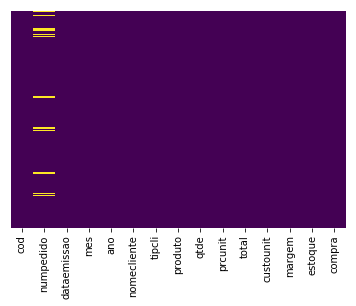

In [140]:
sns.heatmap(data.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [141]:
#Removendo a coluna numpedido por conter alguns valores nulos e não ser um feature importante para a resolução do problema:
data.drop(['numpedido'],axis=1, inplace=True)
data.head(5)

,cod,dataemissao,mes,ano,nomecliente,tipcli,produto,qtde,prcunit,total,custounit,margem,estoque,compra
0,1,03/01/2019,1,2019,CLI3460,A,5140,240,23.64,5673.60,10.232,13.408,530,COMPRA
1,2,03/01/2019,1,2019,CLI3433,A,5140,48,23.64,1134.72,10.232,13.408,563,COMPRA
2,3,03/01/2019,1,2019,CLI3455,A,5140,16,23.64,378.24,10.232,13.408,229,COMPRA
3,4,03/01/2019,1,2019,CLI3587,A,5140,8,23.64,189.12,10.232,13.408,269,COMPRA
4,5,03/01/2019,1,2019,CLI3472,A,5140,8,23.64,189.12,9.050,14.590,119,COMPRA


In [142]:
# Vendas por Produto

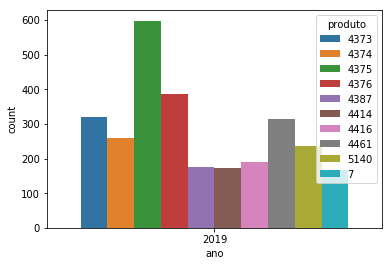

In [143]:
sns.countplot(x='ano',hue='produto',data=data)

In [144]:
# Clintes que compraram no perído ordenado por quantidade comprada, idenficando os 10 princiais.

In [145]:
by_cliente_produto = data[['nomecliente','produto','qtde']].groupby(["nomecliente"]).sum()
topcliente = by_cliente_produto.sort_values(by=["qtde"],ascending=False)
topcliente.head(10)

,qtde
nomecliente,
CLI1889,65343
CLI3562,30997
CLI2259,11361
CLI3436,9814
CLI3460,9256
CLI3433,9111
CLI761,9086
CLI3454,7903
CLI3226,7526


In [146]:
# Calculando a media de venda por mes dos produtos

In [147]:
by_produto_ano = data[['produto','mes','qtde']].groupby(["produto","mes"]).mean()
by_produto_ano.sort_values(by='produto',ascending=True)

qtde
produto mes            
4373    1     59.468750
        9     87.588235
        8     89.565217
        7    176.371429
        5     80.516129
        4     71.222222
        6     66.611111
        2    138.973684
        12   134.000000
        11   140.466667
        10    98.700000
        3     95.562500
4374    5    109.931034
        9    312.833333
        8     95.764706
        7     56.750000
        6     71.041667
        4     60.790698
        11    93.888889
        2    110.370370
        12   173.111111
        10    91.333333
        1     58.300000
        3     67.100000
4375    5    168.190476
        9    158.052632
        8    321.171875
        7    154.938776
        6     93.500000
        4     74.347222
...                 ...
4461    4     34.785714
        10    55.875000
        2     71.159091
        12    59.125000
        11    58.800000
        1     71.238095
        3     28.230769
5140    9     91.071429
        8      4.000000
        7      1.000000
        5     62.000000
        4      4.285714
        6     68.509091
        2     54.925926
        12   127.351351
        11    70.800000
        10   119.666667
        1     56.195122
        3     62.909091
7       7     54.074074
        6     48.750000
        5     22.368421
        4    229.900000
        11   238.600000
        2     14.916667
        10    56.272727
        1    235.066667
        8     50.000000
        3     20.800000
        9    252.000000

[118 rows x 1 columns]

In [152]:
# Grafico de vendas por mes(todos os anos)

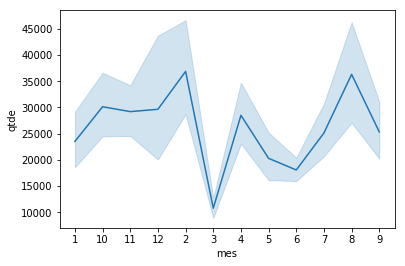

In [153]:
sns.lineplot(x="mes", y="qtde", data=data, estimator=np.sum)

In [154]:
# Vendas mensal(todos os anos) e Produto

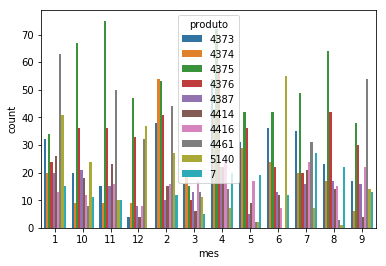

In [155]:
sns.countplot(x='mes',hue='produto',data=data)

In [156]:
# Venda Méida Por Mes(todos os anos) e Produto

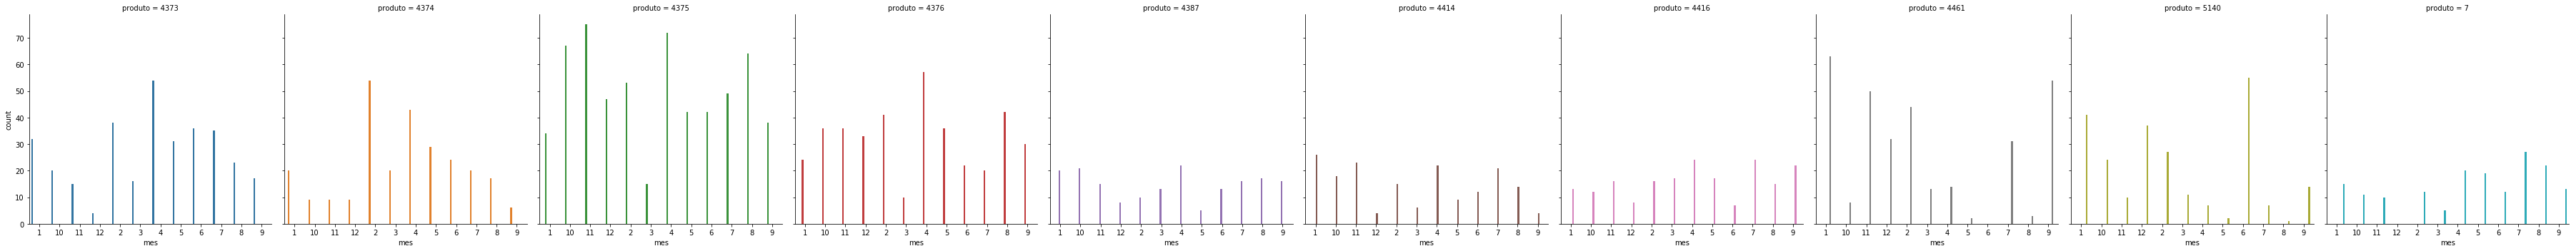

In [157]:
sns.catplot(x='mes', hue='produto', col='produto', kind='count', data=data, estimator=np.mean)

# Tratando o dataset para treino


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # biblioteca de visualização utilizada pelo pandas e pelo seaborn
import seaborn as sns # biblioteca de visualização com mais opções de gráficos
 #comando necessário para que as imagens sejam exibidas aqui mesmo no notebook
%matplotlib inline

In [163]:
df = data
df.head(5)

,cod,dataemissao,mes,ano,nomecliente,tipcli,produto,qtde,prcunit,total,custounit,margem,estoque,compra
0,1,03/01/2019,1,2019,CLI3460,A,5140,240,23.64,5673.60,10.232,13.408,530,COMPRA
1,2,03/01/2019,1,2019,CLI3433,A,5140,48,23.64,1134.72,10.232,13.408,563,COMPRA
2,3,03/01/2019,1,2019,CLI3455,A,5140,16,23.64,378.24,10.232,13.408,229,COMPRA
3,4,03/01/2019,1,2019,CLI3587,A,5140,8,23.64,189.12,10.232,13.408,269,COMPRA
4,5,03/01/2019,1,2019,CLI3472,A,5140,8,23.64,189.12,9.050,14.590,119,COMPRA


In [164]:
# Elimar os atributos que nao influencia na analise

In [165]:
df.drop(['cod','dataemissao','nomecliente'],axis=1, inplace=True)
df.head(10)

,mes,ano,tipcli,produto,qtde,prcunit,total,custounit,margem,estoque,compra
0,1,2019,A,5140,240,23.64,5673.60,10.232,13.408,530,COMPRA
1,1,2019,A,5140,48,23.64,1134.72,10.232,13.408,563,COMPRA
2,1,2019,A,5140,16,23.64,378.24,10.232,13.408,229,COMPRA
3,1,2019,A,5140,8,23.64,189.12,10.232,13.408,269,COMPRA
4,1,2019,A,5140,8,23.64,189.12,9.050,14.590,119,COMPRA
5,1,2019,A,5140,24,23.64,567.36,10.232,13.408,341,COMPRA
6,1,2019,A,5140,72,23.64,1702.08,10.232,13.408,34,COMPRA
7,1,2019,B,5140,8,25.00,200.00,10.300,14.700,152,COMPRA
8,1,2019,A,5140,8,23.64,189.12,9.050,14.590,256,COMPRA
9,1,2019,A,5140,32,23.64,756.48,9.050,14.590,19,COMPRA


In [166]:
# Converter tipo cliente em One Hot Encode

In [167]:
df=pd.concat([df,pd.get_dummies(df['tipcli'],prefix='tipcli')], axis=1)
df.drop(['tipcli'],axis=1, inplace=True)
df.head(3)

,mes,ano,produto,qtde,prcunit,total,custounit,margem,estoque,compra,tipcli_A,tipcli_B,tipcli_C
0,1,2019,5140,240,23.64,5673.60,10.232,13.408,530,COMPRA,1,0,0
1,1,2019,5140,48,23.64,1134.72,10.232,13.408,563,COMPRA,1,0,0
2,1,2019,5140,16,23.64,378.24,10.232,13.408,229,COMPRA,1,0,0


In [168]:
# Subtistuir valor da coluna Compra( Compra = 1 e NaoCompra = 0)

In [169]:
df["compra"] = df["compra"].replace("COMPRA", "1")
df["compra"] = df["compra"].replace("NAOCOMPRA", "0")

In [170]:
df.head(5)

,mes,ano,produto,qtde,prcunit,total,custounit,margem,estoque,compra,tipcli_A,tipcli_B,tipcli_C
0,1,2019,5140,240,23.64,5673.60,10.232,13.408,530,1,1,0,0
1,1,2019,5140,48,23.64,1134.72,10.232,13.408,563,1,1,0,0
2,1,2019,5140,16,23.64,378.24,10.232,13.408,229,1,1,0,0
3,1,2019,5140,8,23.64,189.12,10.232,13.408,269,1,1,0,0
4,1,2019,5140,8,23.64,189.12,9.050,14.590,119,1,1,0,0


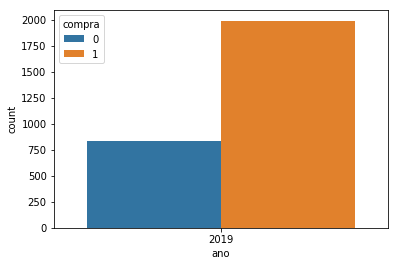

In [171]:
sns.countplot(x='ano',hue='compra',data=df)

# 2. Treinar o Classificador

In [172]:
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [173]:
train = df # Transferindo o dataset DF para train, para efetuar os treinos
train.head(5)

,mes,ano,produto,qtde,prcunit,total,custounit,margem,estoque,compra,tipcli_A,tipcli_B,tipcli_C
0,1,2019,5140,240,23.64,5673.60,10.232,13.408,530,1,1,0,0
1,1,2019,5140,48,23.64,1134.72,10.232,13.408,563,1,1,0,0
2,1,2019,5140,16,23.64,378.24,10.232,13.408,229,1,1,0,0
3,1,2019,5140,8,23.64,189.12,10.232,13.408,269,1,1,0,0
4,1,2019,5140,8,23.64,189.12,9.050,14.590,119,1,1,0,0


In [176]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['compra'],axis=1), 
                                                    train['compra'], test_size=0.30, 
                                                    random_state=101)

In [177]:
# Criar um objeto do classificador DecisionTreeClassifier()

In [178]:
dtc = DecisionTreeClassifier()

In [179]:
# Treinar o modelo dtc chamando a função fit

In [180]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [181]:
# Fazer as predições passanto o X_TEST

In [183]:
predictions = dtc.predict(X_test)

In [184]:
# Matrix de confusão

In [186]:
cnf_matrix = confusion_matrix(y_test, predictions)
cnf_matrix

array([[245,   3],
       [  2, 597]], dtype=int64)

In [187]:
#Plotar matriz de confusão

In [188]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[245   3]
 [  2 597]]


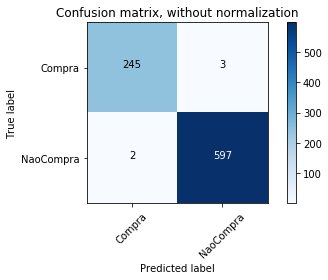

In [189]:
plot_confusion_matrix(cnf_matrix, classes=['Compra','NaoCompra'],
                      title='Confusion matrix, without normalization')

In [191]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       248
           1       0.99      1.00      1.00       599

   micro avg       0.99      0.99      0.99       847
   macro avg       0.99      0.99      0.99       847
weighted avg       0.99      0.99      0.99       847



In [192]:
# Rank dos tributos mais relevantes

In [193]:
df_import_features = dict(zip(train.drop(['compra'],axis=1), dtc.feature_importances_))
df_import_features = pd.DataFrame.from_dict(df_import_features, orient='index', columns = ['value'])
df_import_features = df_import_features.sort_values(['value'], ascending=False)
df_import_features

,value
tipcli_A,0.785418
qtde,0.082735
estoque,0.071885
margem,0.050557
custounit,0.005186
mes,0.001340
produto,0.001215
total,0.001042
tipcli_C,0.000621
ano,0.000000


In [ ]:
# Plotar atributos mais relevantes

In [194]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

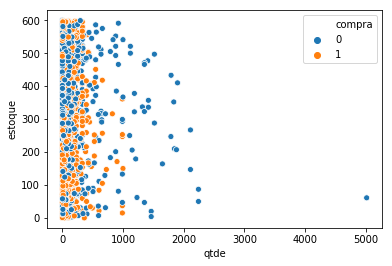

In [195]:
ax = sns.scatterplot(x=train["qtde"], y=train["estoque"], hue="compra",data=train)

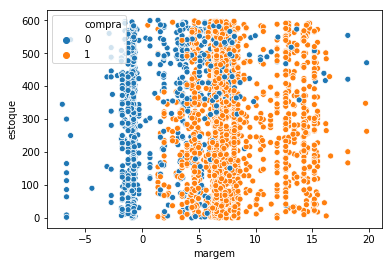

In [196]:
ax = sns.scatterplot(x=train["margem"], y=train["estoque"], hue="compra",data=train)

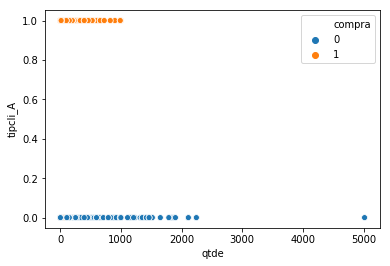

In [197]:
ax = sns.scatterplot(x=train["qtde"], y=train["tipcli_A"], hue="compra",data=train)

In [ ]:
#Teste unitário do modelto.

In [208]:
train.head(0)

,mes,ano,produto,qtde,prcunit,total,custounit,margem,estoque,compra,tipcli_A,tipcli_B,tipcli_C


In [209]:
# Criar um produto1 contendo informações do produto a ser analisado pelo modelo.
produto1 = [1,2019,4391,11,4.11,45.21,6.4655,-2.3555,260,0,1,0]
produto2 = [8,2019,7,11,4.11,45.21,8.55,4.52,160,0,1,0]

In [206]:
#Submetendo o Produto1 para o modelo analisar se comprar ou não. [0] = Nao compra  [1] = Compra
dtc.predict([produto1])

array(['0'], dtype=object)

In [207]:
#Submetendo o Produto2 para o modelo analisar se comprar ou não. [0] = Nao compra  [1] = Compra
dtc.predict([produto2])

array(['1'], dtype=object)